In [6]:
import os
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [13]:
mit_train_df = pd.read_csv('../Dataset/mitbih_train.csv', header=None)
mit_test_df = pd.read_csv('../Dataset/mitbih_test.csv', header=None)

mit_df = pd.concat([mit_train_df, mit_test_df], axis=0)

In [14]:
mit_df.rename(columns={187: 'class'}, inplace=True)

In [15]:
mit_df['class'].unique()

array([0., 1., 2., 3., 4.])

- 0: "Normal"
- 1: "Artial Premature"
- 2: "Premature ventricular contraction"
- 3: "Fusion of ventricular and normal"
- 4: "Fusion of paced and normal"

In [4]:
labels = {
    0: "Normal",
    1: "Artial Premature",
    2: "Premature ventricular contraction",
    3: "Fusion of ventricular and normal",
    4: "Fusion of paced and normal"
}

In [20]:
mit_df['label'] = mit_df['class'].map(labels)
mit_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 109446 entries, 0 to 21891
Columns: 189 entries, 0 to label
dtypes: float64(188), object(1)
memory usage: 158.7+ MB


In [21]:
mit_df.to_csv('../Dataset/mitbih.csv', index=False)

### Design a EDA for closure

In [7]:
# Loading Dataset

mit_df = pd.read_csv('../Dataset/mitbih.csv')

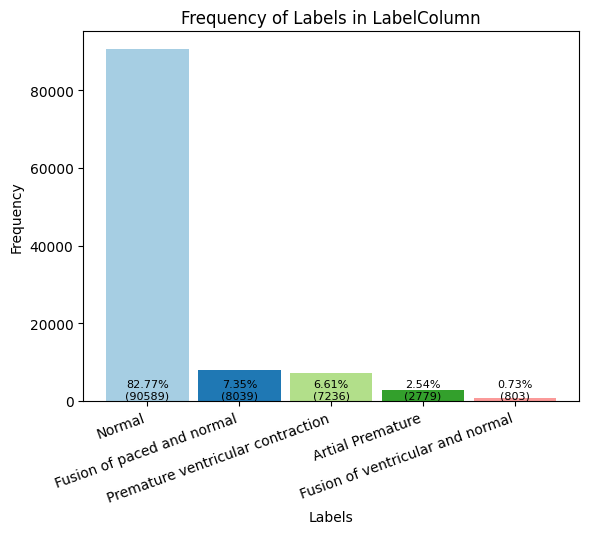

In [3]:
label_counts = mit_df['label'].value_counts()
label_percentages = label_counts / label_counts.sum() * 100

ax = label_counts.plot(kind='bar', color=plt.cm.Paired(range(len(label_percentages))), width=0.9)

plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Frequency of Labels in LabelColumn')

# Annotate each bar with its percentage and frequency on top
for i, (percentage, frequency) in enumerate(zip(label_percentages, label_counts)):
    ax.annotate(f'{percentage:.2f}%\n({frequency})', (i, percentage + 0.5), ha='center', va='bottom', fontsize=8)

# Rotate x-axis labels for better visibility
plt.xticks(rotation=20, ha='right')

plt.show()

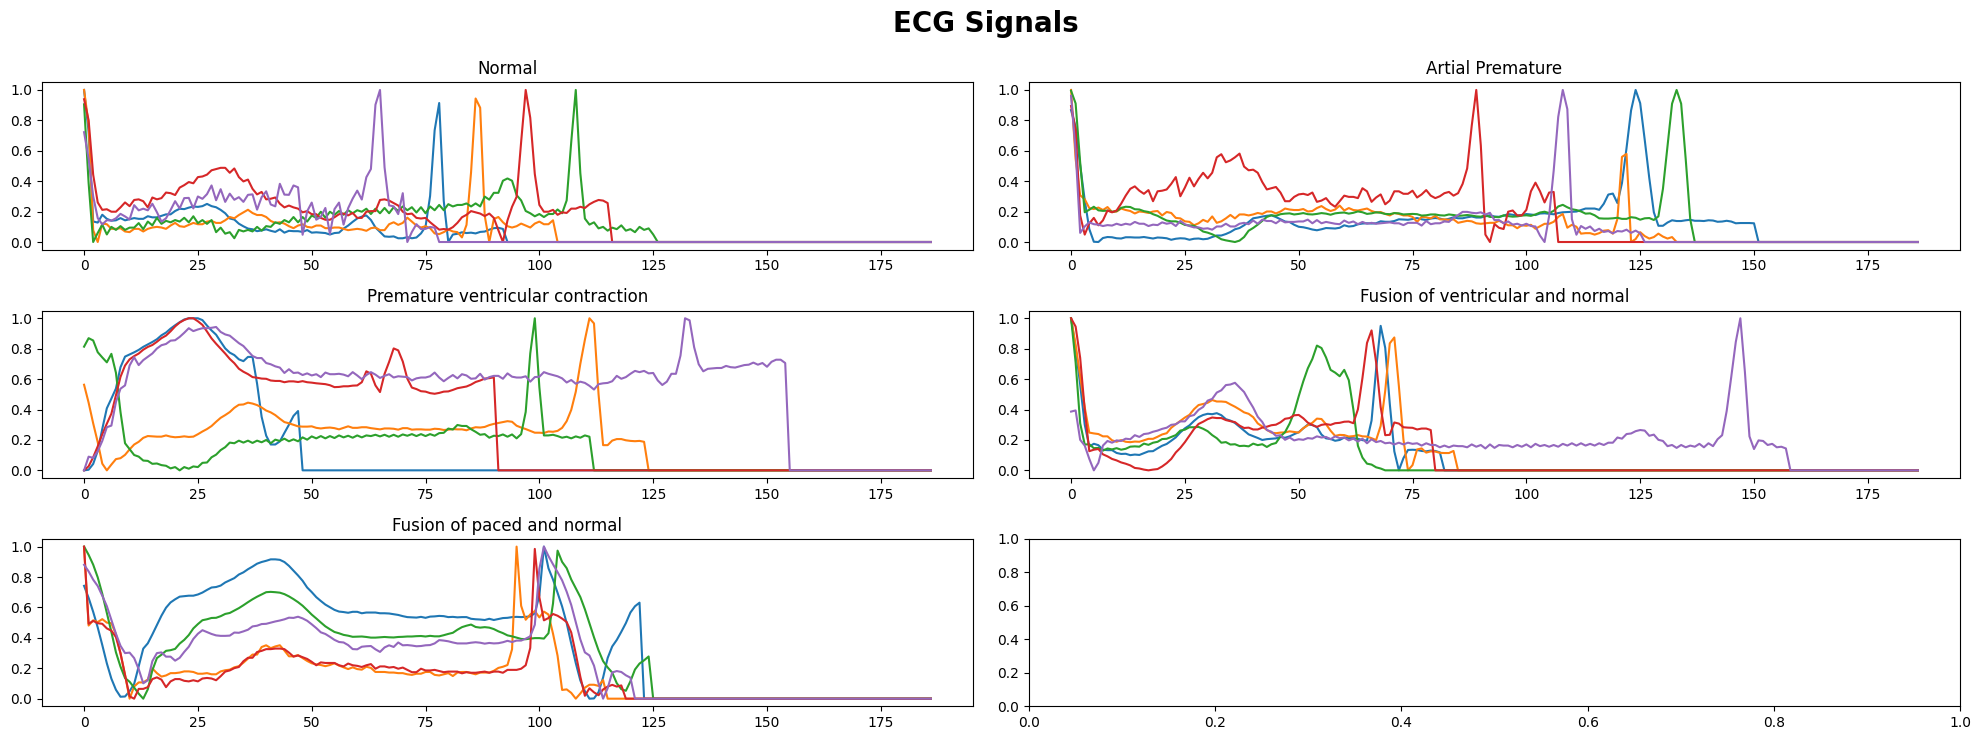

In [26]:

N = 5
samples = [mit_df.loc[mit_df['class'] == cls].sample(N) for cls in range(N)]
titles = [labels[cls] for cls in range(5)]

with plt.style.context('_classic_test_patch'):
    fig, axs = plt.subplots(3, 2, figsize=(20, 7))
    for i in range(5):
        ax = axs.flat[i]
        ax.plot(samples[i].values[:,:-2].transpose())
        ax.set_title(titles[i])
        #plt.ylabel("Amplitude")

    plt.tight_layout()
    plt.suptitle("ECG Signals", fontsize=20, y=1.05, weight="bold")
    # plt.savefig(f"signals_per_class.svg",
    #                 format="svg",bbox_inches='tight', pad_inches=0.2)
        
    # plt.savefig(f"signals_per_class.png", 
    #                 format="png",bbox_inches='tight', pad_inches=0.2) 

In [8]:
mit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109446 entries, 0 to 109445
Columns: 189 entries, 0 to label
dtypes: float64(188), object(1)
memory usage: 157.8+ MB


In [8]:
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

train_df, test_df = train_test_split(mit_df, test_size = 0.2, random_state = 42)

In [9]:
# Normalize the time series data using StandardScaler
scaler = StandardScaler()
train_df.iloc[:, :-2] = scaler.fit_transform(train_df.iloc[:, :-2])
test_df.iloc[:, :-2] = scaler.transform(test_df.iloc[:, :-2])


In [10]:
# Define a function to create a tf.data.Dataset from a pandas DataFrame
def create_dataset(dataframe, batch_size=32, shuffle=True):
    
    labels = dataframe.pop('label') 
    classes = dataframe.pop('class')

    dataset = tf.data.Dataset.from_tensor_slices((dataframe.values, classes.values))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(dataframe))

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

In [11]:
# Create tf.data.Datasets for training and testing
batch_size = 32
train_dataset = create_dataset(train_df, batch_size=batch_size)
test_dataset = create_dataset(test_df, batch_size=batch_size, shuffle=False)

In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the CNN-LSTM model
def create_model(input_shape, num_classes):
    model = models.Sequential()

    # CNN layers
    model.add(layers.Conv1D(32, kernel_size=5, activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Conv1D(64, kernel_size=5, activation='relu'))
    model.add(layers.MaxPooling1D(pool_size=2))

    # LSTM layer
    model.add(layers.LSTM(64, activation='relu'))

    # Dense layers
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

# Input shape based on your time series data
input_shape = (187, 1)

# Number of output classes
num_classes = 5  # Replace with your actual number of classes

# Create the model
model = create_model(input_shape, num_classes)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model on the training dataset
num_epochs = 10  # Adjust as needed
model.fit(train_dataset, epochs=num_epochs)

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


Epoch 1/10


2737/2737 [==============================] - 63s 22ms/step - loss: 0.3235 - accuracy: 0.9111
Epoch 2/10
2737/2737 [==============================] - 65s 24ms/step - loss: 0.1545 - accuracy: 0.9572
Epoch 3/10
2737/2737 [==============================] - 75s 27ms/step - loss: 0.1253 - accuracy: 0.9657
Epoch 4/10
2737/2737 [==============================] - 93s 34ms/step - loss: 0.1076 - accuracy: 0.9707
Epoch 5/10
2737/2737 [==============================] - 90s 33ms/step - loss: 0.0948 - accuracy: 0.9739
Epoch 6/10
2737/2737 [==============================] - 95s 34ms/step - loss: 0.0847 - accuracy: 0.9766
Epoch 7/10
2737/2737 [==============================] - 91s 33ms/step - loss: 0.0766 - accuracy: 0.9789
Epoch 8/10
2737/2737 [==============================] - 94s 34ms/step - loss: 0.0707 - accuracy: 0.9804
Epoch 9/10
2737/2737 [==============================] - 88s 32ms/step - loss: 0.0652 - accuracy: 0.9815
Epoch 10/10
685/685 [==============================] - 13s 17m